In [1]:
%matplotlib inline
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

In [2]:
def show(images) :
    if type(images) is np.ndarray:
        images = [images]
    l = len(images)
    fig = plt.figure()
    fig.set_size_inches(20,20)
    for i,image in enumerate(images):
        fig.add_subplot(1, l, i+1)
        if len(image.shape) == 3:
            plt.imshow(image)
            b,g,r = cv2.split(image)
            plt.imshow(cv2.merge((r,g,b)))
        else:
            plt.imshow(image, cmap='Greys')
          
    plt.show()


In [3]:
def get_frame_number(clip, n) :
    frame = clip.get_frame(float(n)/clip.fps)
    bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    return bgr_frame

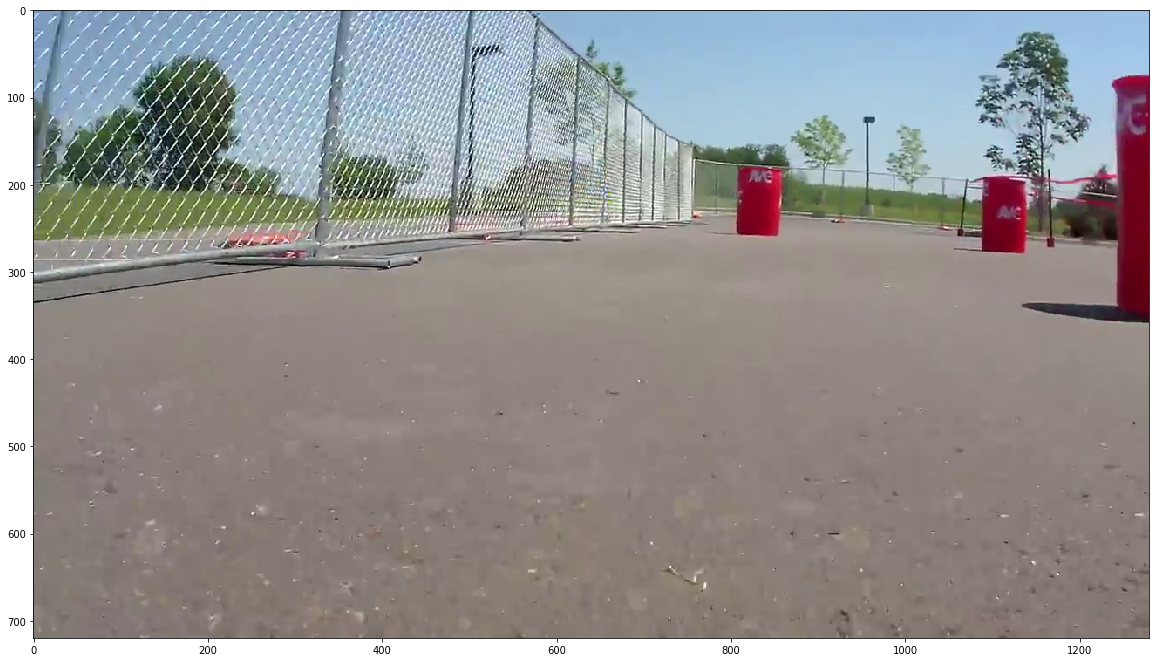

In [4]:
#im = cv2.imread('input/red_barrels_3.png')
clip = VideoFileClip('videos/video1.mp4')
frame = clip.get_frame(22.0)
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
show(frame)
im = frame

In [5]:
int(clip.fps * clip.duration)

1973

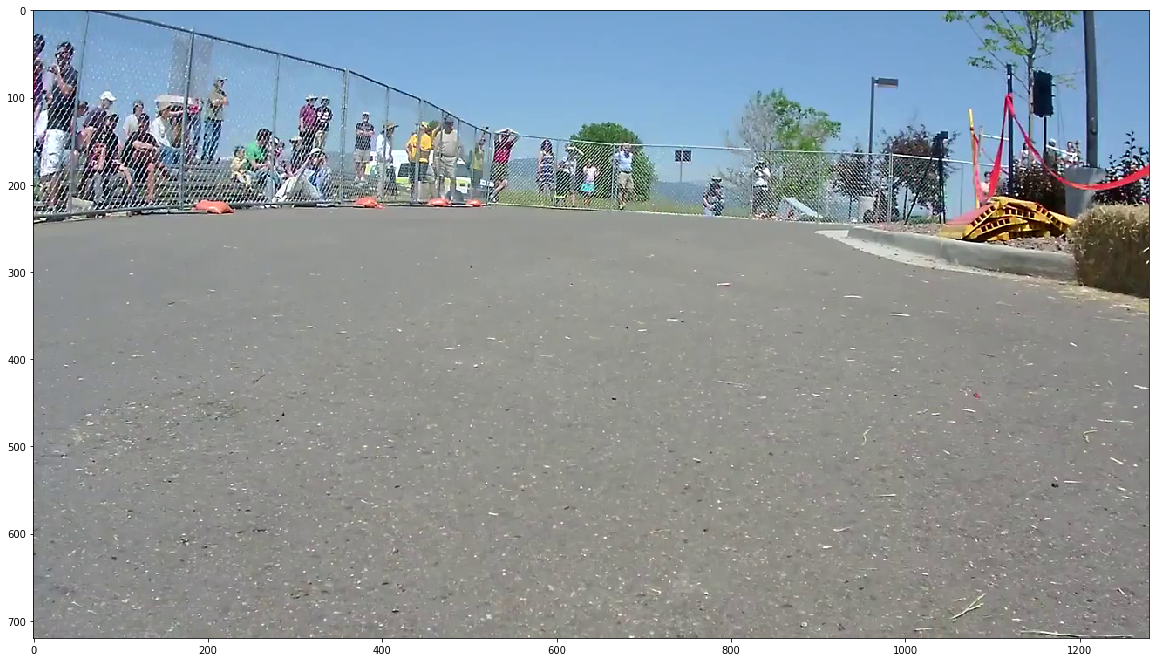

In [6]:
show(get_frame_number(clip, 10))

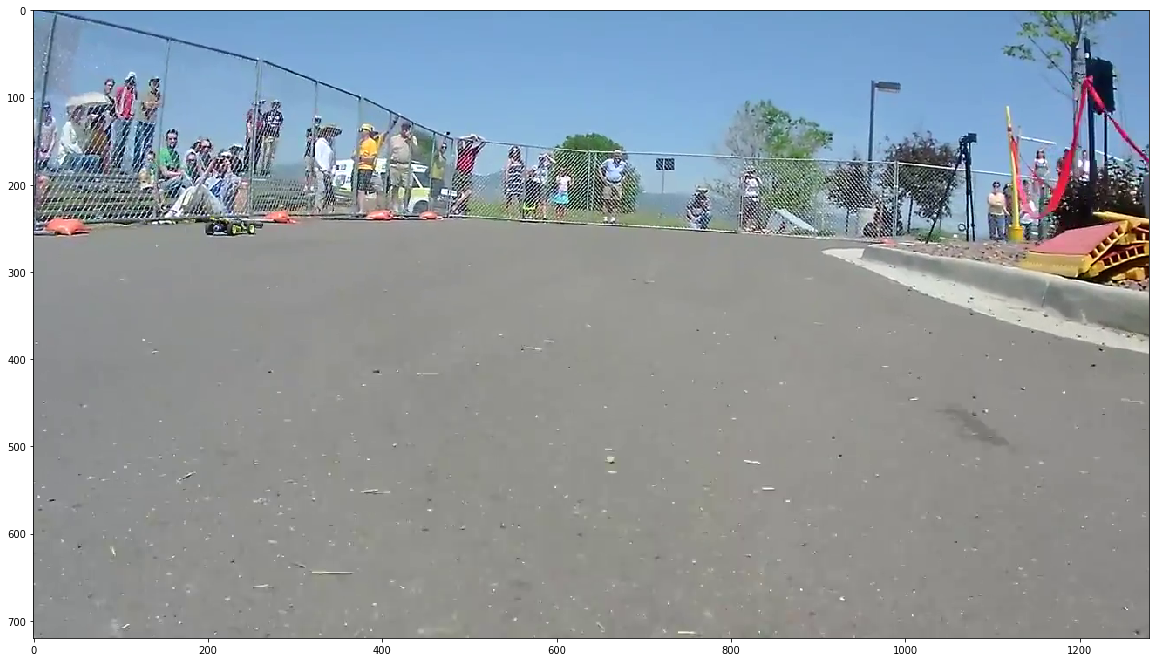

In [7]:
show(get_frame_number(clip,200))

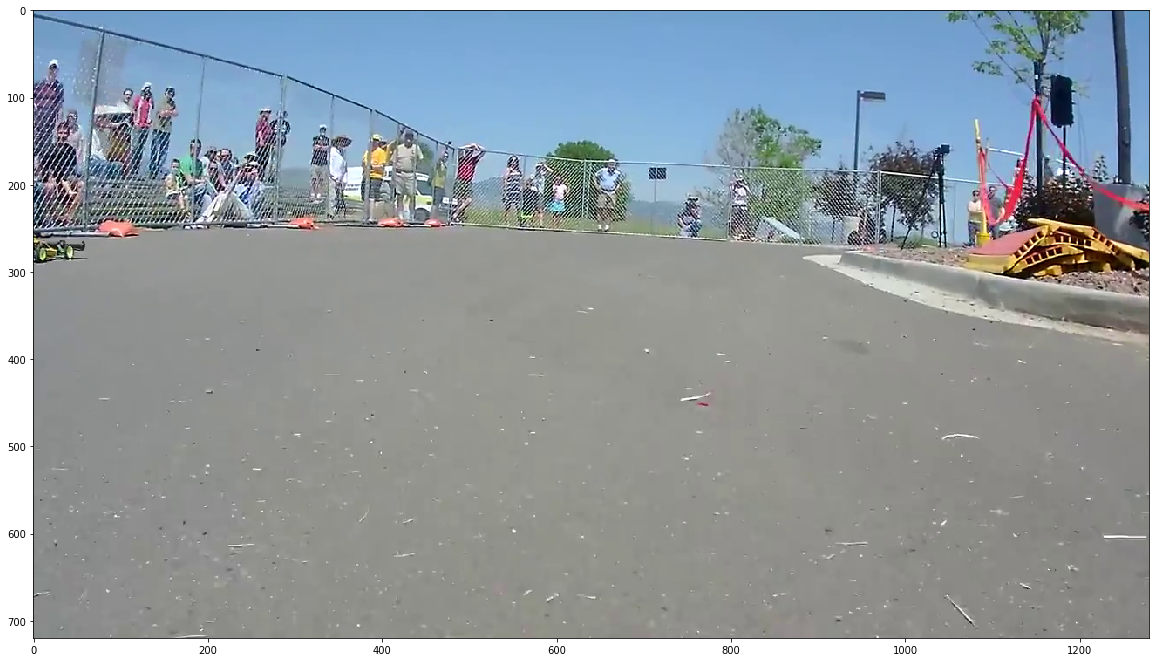

In [8]:
show(get_frame_number(clip, 190))

In [9]:
def split_up(min,max,ticks):
    return [int(min + (max-min) * i / float(ticks)) for i in range(ticks+1)]

In [10]:
vanishing_point_xy = (718,270)

In [11]:
def draw_vanishing_lines(im):
    im_h, im_w, _ = im.shape
    radius = 10
    thickness = 3

    color = (255,50,50,100)

    im = cv2.circle(im,vanishing_point_xy,radius,color)

    for x in split_up(0-5000,im_w+5000,ticks=30):
      cv2.line(im, (x,im_h), vanishing_point_xy, color)


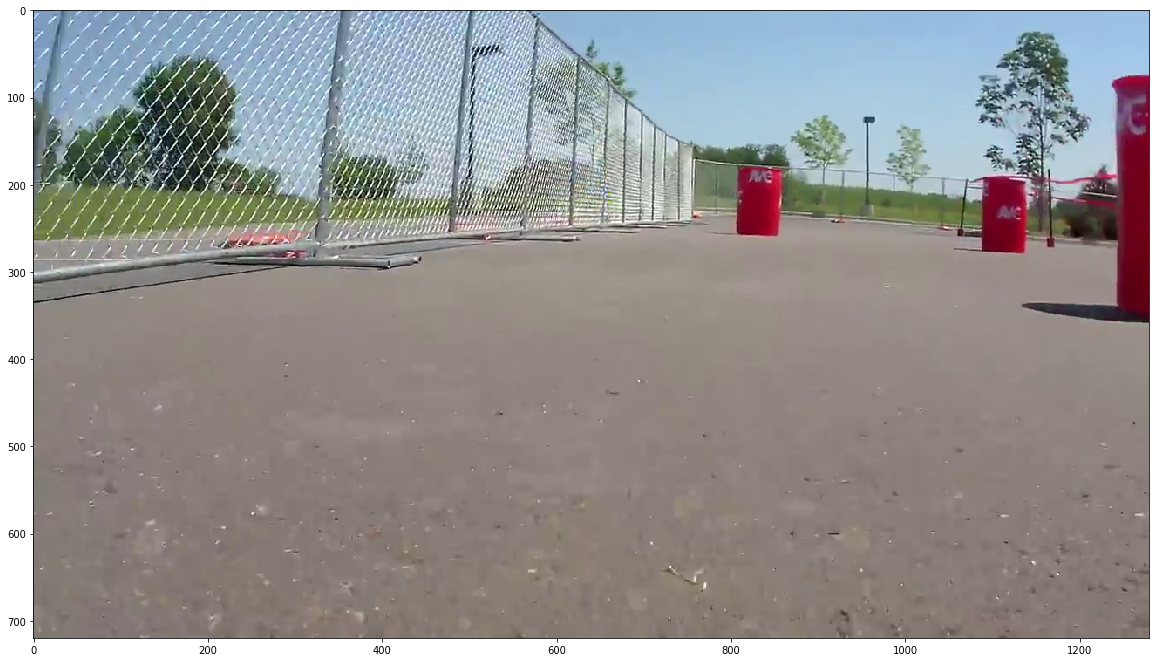

In [12]:
show(im)

In [13]:
im=cv2.blur(im,(5,5))

In [14]:
def get_red_mask(img):

    # lower mask (0-10)
    b,g,r = cv2.split(img)
    lower_red = np.array([0,0,50])
    upper_red = np.array([100,25,255])
    mask0 = cv2.inRange(img, lower_red, upper_red)

    # join masks
    return mask0#mask = np.invert(mask0+mask1)
    
    #return mask


In [15]:
def mask_image(img, mask):
    output_img = img.copy()
    output_img[np.where(mask==0)] = 0
    return output_img


In [16]:
def find_red(img):
    return mask_image(img, get_red_mask(img))


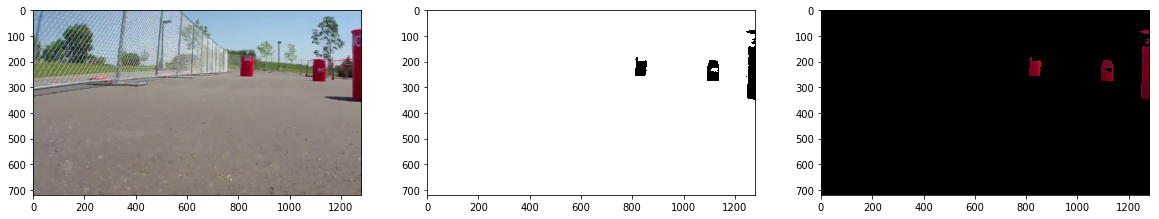

In [17]:
im_mask = get_red_mask(im)
im_red = find_red(im)
show([im, im_mask, im_red])


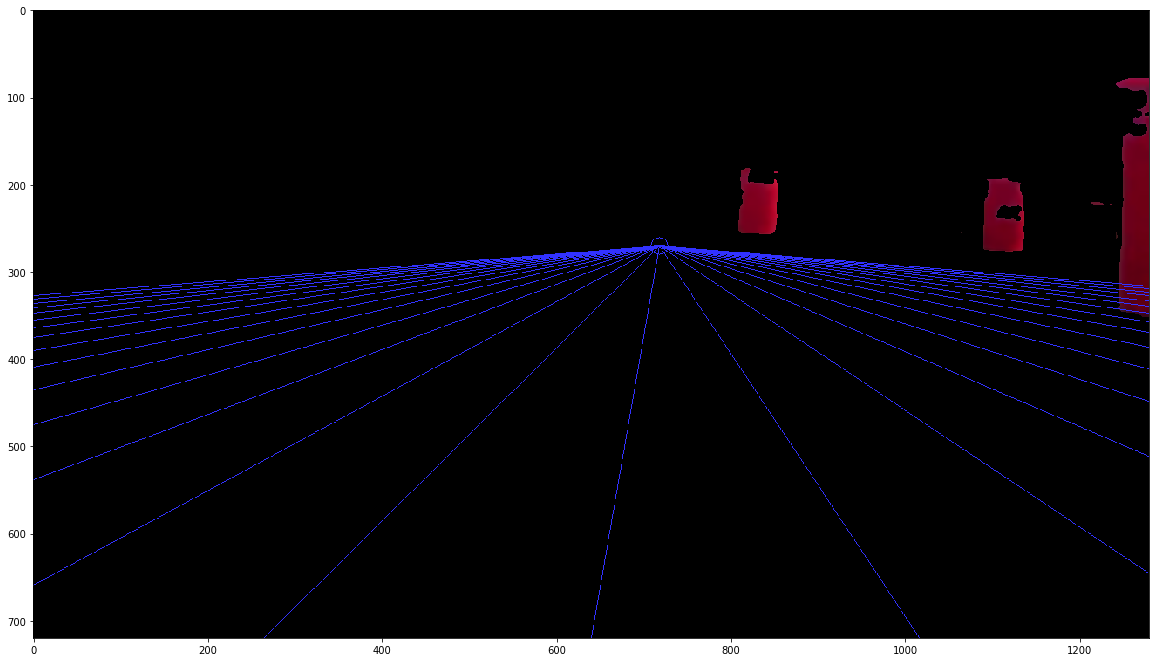

In [18]:
draw_vanishing_lines(im_red)
show([im_red])

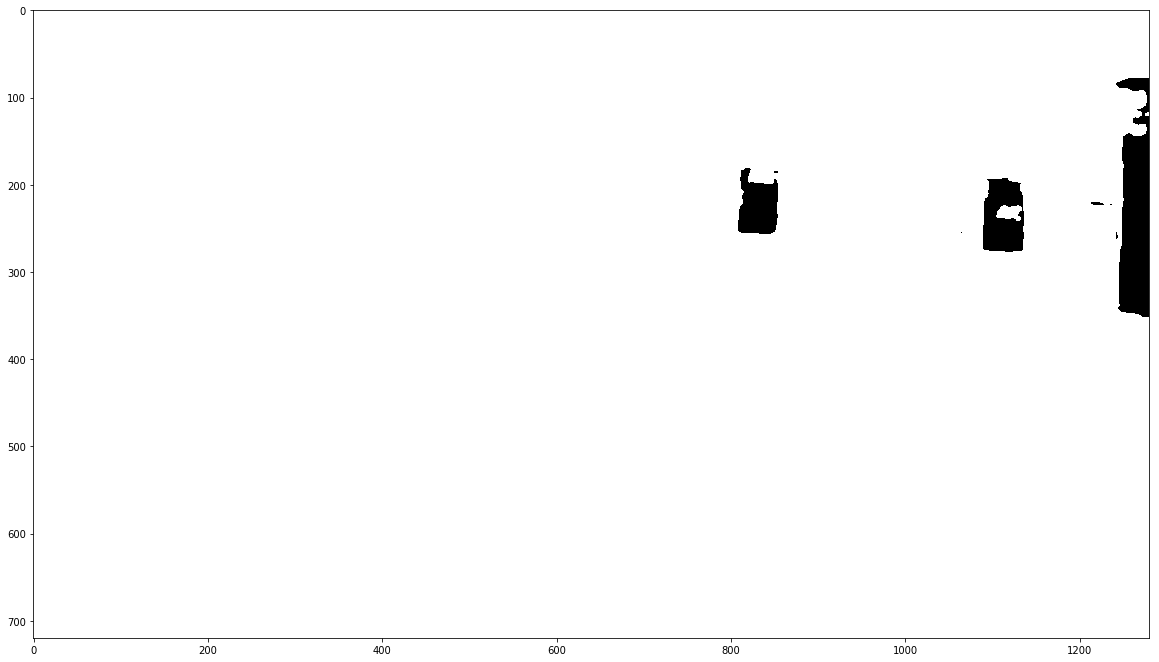

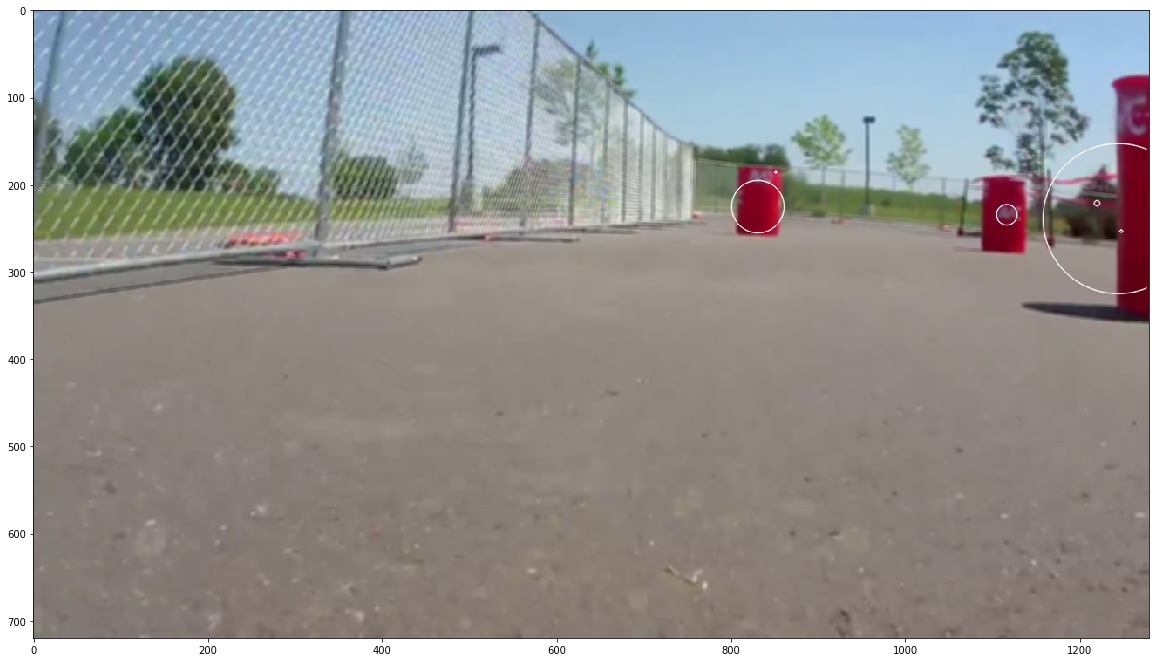

In [19]:
#cv2.SimpleBlobDetector_create
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
params.minArea = 20*20
params.filterByArea = False
params.filterByCircularity = False
params.minCircularity = 0
params.maxCircularity = 1000
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.maxArea = 300*3000
detector = cv2.SimpleBlobDetector_create(params)
 
# Detect blobs.
keypoints = detector.detect(im_mask)
im_blank = np.zeros_like(im)
 
horizon = vanishing_point_xy[1]
#keypoints = [k for k in keypoints if k.pt[1] < vanishing_point_xy[1]+30]
#keypoints = [k for k in keypoints if k.pt[1]+k.size/2. > vanishing_point_xy[1]]

# Draw detected blobs as circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (255,255,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


show(im_mask)
show(im_with_keypoints)

In [20]:
horizon


270

In [21]:
# top of barrel should be above horizon, bottom of barrel should be below horizon
# middle of barrel should be above horizon

In [22]:
len(keypoints)

6

In [23]:
def describe_keypoints(keypoints):
    for k in keypoints:
        print('angle', k.angle)
        print('class_id',k.class_id)
        print('octave', k.octave)
        print('pt',k.pt)
        print('response',k.response)
        print('size',k.size)
        print()

# describe_keypoints(keypoints)

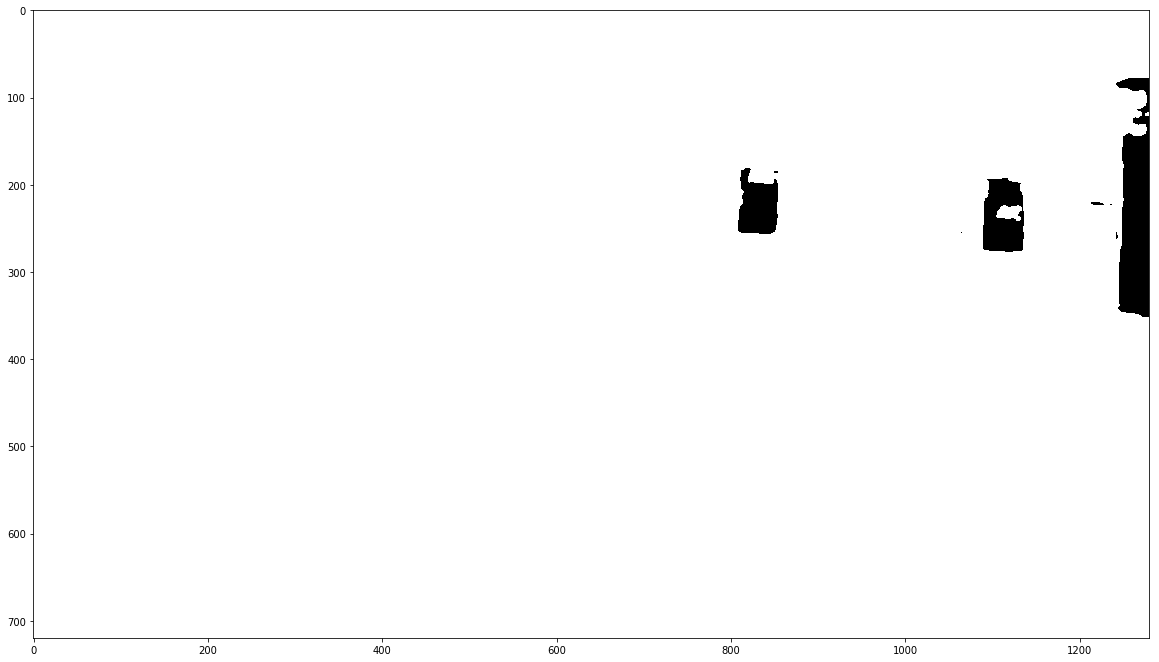

In [24]:
show(im_mask)

In [25]:
#im_dilated =cv2.dilate(im_mask,(180,180))
#im_eroded = cv2.erode(im_dilated,(180,180))
#show([im_eroded])
#im_mask = im_eroded

In [26]:
# see http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
im_,contours,hierarchy = cv2.findContours(im_mask,cv2.RETR_TREE ,2)

In [27]:
def circularity(contour):
    perimeter = cv2.arcLength(contour, True)
    return 4 * math.pi * cv2.contourArea(contour) / (perimeter * perimeter)


In [28]:
def centroid(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)
    

In [29]:
im_draw = im.copy()

In [30]:
for contour, i in zip(contours,range(len(contours))):
    hull = cv2.convexHull(contour,contour)
    contour = hull
    cv2.drawContours(im_draw,[contour],0,(0,0,255),2)
    area = cv2.contourArea(contour)
    if area < 20*20:
        continue
    print()
    print(i)
    print('len',len(contour))
    print('area',cv2.contourArea(contour))
    if(len(contour)>=5): 
        e = cv2.fitEllipse(contour)
        cv2.ellipse(im_draw, e, (255,255,155))
        print('Ellipse',e)
    if(len(contour)>1):
        print('circularity', circularity(contour))
        print(cv2.arcLength(contour,True))
        cv2.putText(im_draw,str(round(circularity(contour),2)),centroid(contour),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))


    


4
len 16
area 3578.5
Ellipse ((1112.414306640625, 237.79922485351562), (54.663917541503906, 97.10737609863281), 179.7842559814453)
circularity 0.784047322393683
239.48830199241638

5
len 16
area 483.0
Ellipse ((1119.9783935546875, 233.0973358154297), (24.56008529663086, 31.636606216430664), 80.88717651367188)
circularity 0.8436187936842394
84.82138788700104

7
len 21
area 2966.0
Ellipse ((829.3912353515625, 220.52943420410156), (54.555938720703125, 87.24054718017578), 179.02377319335938)
circularity 0.8124270599270961
214.18956816196442

8
len 10
area 9419.0
Ellipse ((1268.7271728515625, 213.86404418945312), (149.0663604736328, 275.0503234863281), 178.68218994140625)
circularity 0.32418696469544883
604.2401177883148


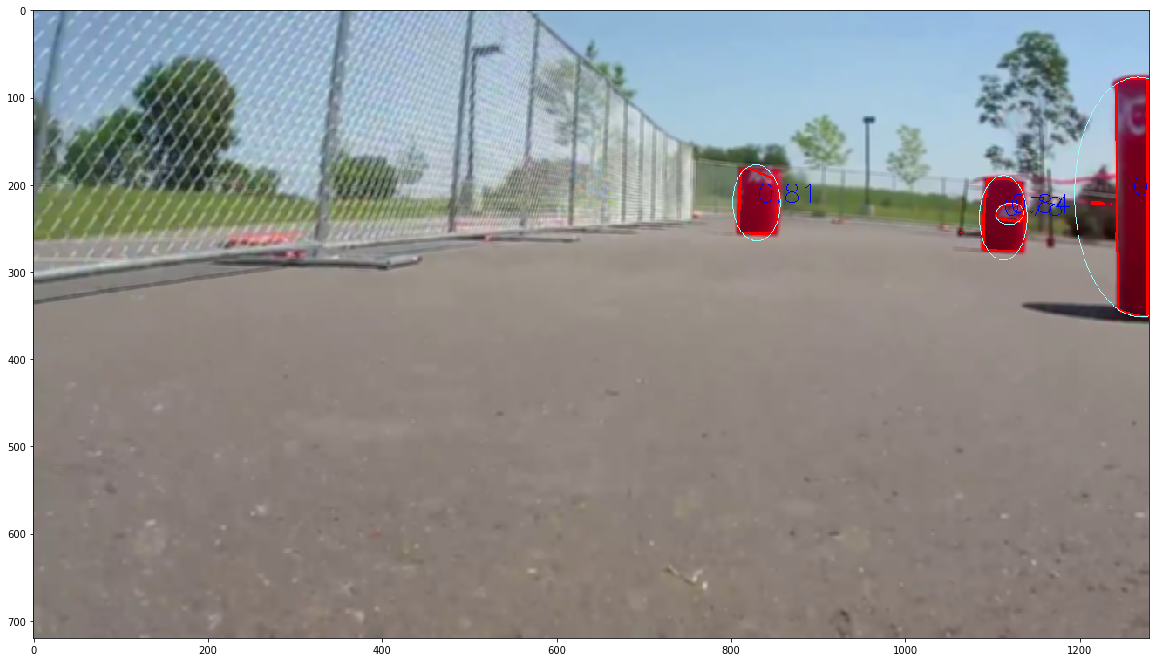

In [31]:
show(im_draw)